# Postgres / PgVector

Notes:

- Reference:
  - https://github.com/aws-samples/rds-postgresql-pgvector/blob/main/rdspg-vector.ipynb (This notebook also uses Sagemaker, but I adapted it to local model)
- I used RDS Postgresql with Pgvector
- PG uses IVFFlat. Build is faster and consumes less memory than HNSW. Query is slower.
- IVFFlat Metrics: L2, Inner product, Cosine.
- Index behaviour can be set by session "SET ivfflat.probes = N". Higher Ns, better recall, worst performance.
- PG also has HNSW
- HNSW Metrics: L2, IP, Cosine
- INdex behaviour ef_search can be set by session
- Hybrid search with @@.

In [4]:
!pip install -U psycopg2-binary pgvector tqdm boto3 requests sagemaker scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.2/886.2 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for pathos from https://files.pythonhosted.org/packages/d8/08/ac94fa6f9eefe32963b8a54e573dab0dbc0d3df24fd34924bd9ce7eab7c4/pathos-0.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for ppft>=1.7.6.7 from https://files.pythonhosted.org/packages/f0/f8/0a493dfdf73edbfe58cae1323aec72d0152f463c7a351bd285e9d500985c/ppft-1.7.6.7-py3-none-any.whl.metadata
  Obtaining dependency information for pox>=0.3.3 from https://files.pythonhosted.org/packages/17/c7/ef7e37e5a895f5de068b408a52bee0710b1092574b6b4ab247a767e9fbd5/pox-0.3.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.0 MB/s eta 0:00:00
  Created wheel for sagemaker: filename=sagemaker-2.187.0-py2.py3-none-any.whl size=1186946 sha256=e80bbcd493b829a

In [1]:
from dotenv import load_dotenv
import os
load_dotenv(override=True)

True

In [2]:
import urllib.request
import os
import json
import boto3
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map
filename = 'data/metadata.json'

def download_metadata(url):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

## The German text has been translated into English and the resulting translation has been stored in this repository for convenience.
download_metadata('https://raw.githubusercontent.com/aws-samples/rds-postgresql-pgvector/master/data/FEIDEGGER_release_1.2.json')

with open(filename) as json_file:
    results = json.load(json_file)

results[0]

/Users/samuel.matioli/.pyenv/versions/3.9.4/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'url': 'https://img01.ztat.net/article/spp-media-p1/3c8812d8b6233a55a5da06b19d780302/dc58460c157b426b817f13e7a2f087c5.jpg?imwidth=400&filter=packshot',
 'descriptions': ['short, sexy, summer, sexy, party, yellow dress, and sleeveless',
  'A yellow dress which is up to about above the knee and has a V-neckline. The dress has a strapless accent',
  'Knee-length fabric dress in yellow with wide skirt, off-the-shoulder with a deep round neckline.',
  'Yellow sleeveless summer dress. It has a slightly rounded V-neck. The dress is longer at the back than at the front.',
  'Airy summer dress that is slightly longer at the back. It is sleeveless, has a v-neck and wide straps.'],
 'split': '7'}

In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [4]:
def generate_embeddings(data):
    r = {}
    r['url'] = data['url']
    r['descriptions'] = data['descriptions']
    r['split'] = data['split']
    inp = {'inputs' : ' '.join( data['descriptions'] ) }
    #vector = cls_pooling( predictor.predict(inp) )
    vector =  model.encode( data['descriptions'])
    r['descriptions_embeddings'] = vector[0]
    return r
    

In [12]:
generate_embeddings(results[0])

{'url': 'https://img01.ztat.net/article/spp-media-p1/3c8812d8b6233a55a5da06b19d780302/dc58460c157b426b817f13e7a2f087c5.jpg?imwidth=400&filter=packshot',
 'descriptions': ['short, sexy, summer, sexy, party, yellow dress, and sleeveless',
  'A yellow dress which is up to about above the knee and has a V-neckline. The dress has a strapless accent',
  'Knee-length fabric dress in yellow with wide skirt, off-the-shoulder with a deep round neckline.',
  'Yellow sleeveless summer dress. It has a slightly rounded V-neck. The dress is longer at the back than at the front.',
  'Airy summer dress that is slightly longer at the back. It is sleeveless, has a v-neck and wide straps.'],
 'split': '7',
 'descriptions_embeddings': [[-0.04569479450583458,
   0.06347130984067917,
   0.10777875036001205,
   0.05883030965924263,
   0.02428731508553028,
   0.03960359841585159,
   0.04813656210899353,
   -0.060212068259716034,
   -0.021498948335647583,
   0.04658284783363342,
   0.05013176426291466,
   -0.07

In [6]:
data = [generate_embeddings(r) for r in results]
len(data)

8792

In [7]:
data[0]

{'url': 'https://img01.ztat.net/article/spp-media-p1/3c8812d8b6233a55a5da06b19d780302/dc58460c157b426b817f13e7a2f087c5.jpg?imwidth=400&filter=packshot',
 'descriptions': ['short, sexy, summer, sexy, party, yellow dress, and sleeveless',
  'A yellow dress which is up to about above the knee and has a V-neckline. The dress has a strapless accent',
  'Knee-length fabric dress in yellow with wide skirt, off-the-shoulder with a deep round neckline.',
  'Yellow sleeveless summer dress. It has a slightly rounded V-neck. The dress is longer at the back than at the front.',
  'Airy summer dress that is slightly longer at the back. It is sleeveless, has a v-neck and wide straps.'],
 'split': '7',
 'descriptions_embeddings': array([-4.56947945e-02,  6.34713098e-02,  1.07778750e-01,  5.88303097e-02,
         2.42873151e-02,  3.96035984e-02,  4.81365621e-02, -6.02120683e-02,
        -2.14989483e-02,  4.65828478e-02,  5.01317643e-02, -7.33195767e-02,
         3.60975484e-03, -8.87948871e-02,  8.6201

In [9]:
import psycopg2
from pgvector.psycopg2 import register_vector
import json 

dbhost = os.environ["PG_ENDPOINT"]
dbport = "5432"
dbuser = os.environ["PG_USER"]
dbpass = os.environ["PG_PASSWORD"]

dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, connect_timeout=10)
dbconn.set_session(autocommit=True)

cur = dbconn.cursor()
cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
register_vector(dbconn)
cur.execute("DROP TABLE IF EXISTS products;")
cur.execute("""CREATE TABLE IF NOT EXISTS products(
               id bigserial primary key, 
               description text, 
               url text, 
               split int, 
               descriptions_embeddings vector(384));""")

for x in data:
    cur.execute("""INSERT INTO products
                      (description, url, split, descriptions_embeddings) 
                  VALUES(%s, %s, %s, %s);""", 
                  (' '.join(x.get('descriptions', [])), x.get('url'), x.get('split'), x.get('descriptions_embeddings') ))

cur.execute("""CREATE INDEX ON products 
               USING ivfflat (descriptions_embeddings vector_l2_ops) WITH (lists = 100);""")
cur.execute("VACUUM ANALYZE products;")

cur.close()
dbconn.close()
print ("Vector embeddings has been successfully loaded into PostgreSQL")

Vector embeddings has been successfully loaded into PostgreSQL


In [12]:
dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, connect_timeout=10)
dbconn.set_session(autocommit=True)

cur = dbconn.cursor()

cur.execute("""SELECT id, url, description, descriptions_embeddings 
            FROM products limit 1;""")

r = cur.fetchall()

for x in r:
    print (x)

cur.close()

(1, 'https://img01.ztat.net/article/spp-media-p1/3c8812d8b6233a55a5da06b19d780302/dc58460c157b426b817f13e7a2f087c5.jpg?imwidth=400&filter=packshot', 'short, sexy, summer, sexy, party, yellow dress, and sleeveless A yellow dress which is up to about above the knee and has a V-neckline. The dress has a strapless accent Knee-length fabric dress in yellow with wide skirt, off-the-shoulder with a deep round neckline. Yellow sleeveless summer dress. It has a slightly rounded V-neck. The dress is longer at the back than at the front. Airy summer dress that is slightly longer at the back. It is sleeveless, has a v-neck and wide straps.', array([-4.56947945e-02,  6.34713098e-02,  1.07778750e-01,  5.88303097e-02,
        2.42873151e-02,  3.96035984e-02,  4.81365621e-02, -6.02120683e-02,
       -2.14989483e-02,  4.65828478e-02,  5.01317643e-02, -7.33195767e-02,
        3.60975484e-03, -8.87948871e-02,  8.62014368e-02, -8.11546762e-03,
        7.66980648e-02,  1.25431335e-02,  5.80854062e-03,  1.1

Product Item Id: 8561


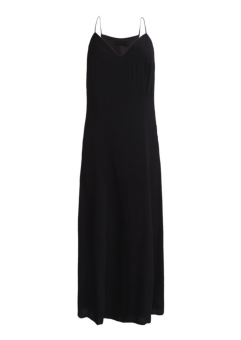

Product Item Id: 6127


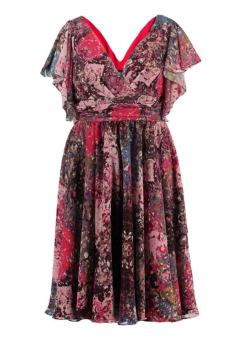

In [15]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import requests

query = "red sleeveless summer wear"
query_embedding = model.encode( query)

cur = dbconn.cursor()

cur.execute("""SELECT id, url, description, descriptions_embeddings 
            FROM products 
            ORDER BY descriptions_embeddings <-> %s limit 2;""", 
            (query_embedding,))

r = cur.fetchall()
urls = []
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

for x in r:
    #print (x)
    url = x[1].split('?')[0]
    urldata = requests.get(url).content
    print ("Product Item Id: " + str(x[0]))
    a = io.imread(url)
    plt.imshow(a)
    plt.axis('off')
    plt.show()

cur.close()

In [19]:
# Running with HNSW
dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, connect_timeout=10)
dbconn.set_session(autocommit=True)
cur = dbconn.cursor()
cur.execute("DROP TABLE IF EXISTS products_hnsw;")
cur.execute("""CREATE TABLE IF NOT EXISTS products_hnsw(
               id bigserial primary key, 
               description text, 
               url text, 
               split int, 
               descriptions_embeddings vector(384));""")

count = 0
for x in data:
    cur.execute("""INSERT INTO products_hnsw
                      (description, url, split, descriptions_embeddings) 
                  VALUES(%s, %s, %s, %s);""", 
                  (' '.join(x.get('descriptions', [])), x.get('url'), x.get('split'), x.get('descriptions_embeddings') ))
    count += 1
    if count % 200 == 0:
        print(f"""Loaded {count}""")

print(f"""Loaded {count}""")


Loaded 200
Loaded 400
Loaded 600
Loaded 800
Loaded 1000
Loaded 1200
Loaded 1400
Loaded 1600
Loaded 1800
Loaded 2000
Loaded 2200
Loaded 2400
Loaded 2600
Loaded 2800
Loaded 3000
Loaded 3200
Loaded 3400
Loaded 3600
Loaded 3800
Loaded 4000
Loaded 4200
Loaded 4400
Loaded 4600
Loaded 4800
Loaded 5000
Loaded 5200
Loaded 5400
Loaded 5600
Loaded 5800
Loaded 6000
Loaded 6200
Loaded 6400
Loaded 6600
Loaded 6800
Loaded 7000
Loaded 7200
Loaded 7400
Loaded 7600
Loaded 7800
Loaded 8000
Loaded 8200
Loaded 8400
Loaded 8600
Loaded 8792


UndefinedObject: access method "hnsw" does not exist


In [23]:
cur.execute("""CREATE INDEX ON products_hnsw 
               USING hnsw (descriptions_embeddings vector_cosine_ops) ;""")
print(f"""Index created""")
cur.execute("VACUUM ANALYZE products_hnsw;")
print(f"""Index analyzed""")

cur.close()
print ("Vector embeddings has been successfully loaded into PostgreSQL")

UndefinedObject: access method "hnsw" does not exist


In [ ]:

cur = dbconn.cursor()

cur.execute("""SELECT id, url, description, descriptions_embeddings 
            FROM products_hnsw limit 1;""")

r = cur.fetchall()

for x in r:
    print (x)

cur.close()

In [ ]:
query = "red sleeveless summer wear"
query_embedding = model.encode( query)

cur = dbconn.cursor()

cur.execute("""SELECT id, url, description, descriptions_embeddings 
            FROM products_hnsw 
            ORDER BY descriptions_embeddings <-> %s limit 2;""", 
            (query_embedding,))

r = cur.fetchall()
urls = []
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

for x in r:
    #print (x)
    url = x[1].split('?')[0]
    urldata = requests.get(url).content
    print ("Product Item Id: " + str(x[0]))
    a = io.imread(url)
    plt.imshow(a)
    plt.axis('off')
    plt.show()

cur.close()